In [181]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(ggplot2, warn.conflicts = FALSE)
library(arrow, warn.conflicts = FALSE)
library(sf, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stars, warn.conflicts = FALSE)

source("src/paths/paths.R")
source("src/load/load.R")
source("src/analysis/data/clim_availability.R")
source("notebooks/integrazioni_regionali/nb_tools/state_avail.R")
source("notebooks/integrazioni_regionali/nb_tools/pairing_procedure.R")

options(repr.plot.width = 9, repr.plot.res = 300)
path.piemonte <- file.path(path.ds, "ARPA", "PIEMONTE")
path.arpa.metadata <- file.path(path.piemonte, "metadata_deduped.geojson")
path.arpa.data <- file.path(path.piemonte, "dataset")
dem <- read_stars("temp/dem/dem30.tif")


In [182]:
arpa.metadata <- read_sf(path.arpa.metadata) |> prepare_metadata(dem)
arpa.metadata <- bind_rows(T_MAX = arpa.metadata, T_MIN = arpa.metadata, .id = "variable")
arpa.ds <- open_dataset(path.arpa.data, format = "feather") |> select(-tclasse)
scia.metadata <- open.dataset("SCIA", "metadata") |> filter(state == "Piemonte")
scia.ds <- open.dataset("SCIA", "data") |> semi_join(scia.metadata, by = "identifier")
scia.metadata <- collect(scia.metadata) |>
    st_md_to_sf() |>
    prepare_metadata(dem)


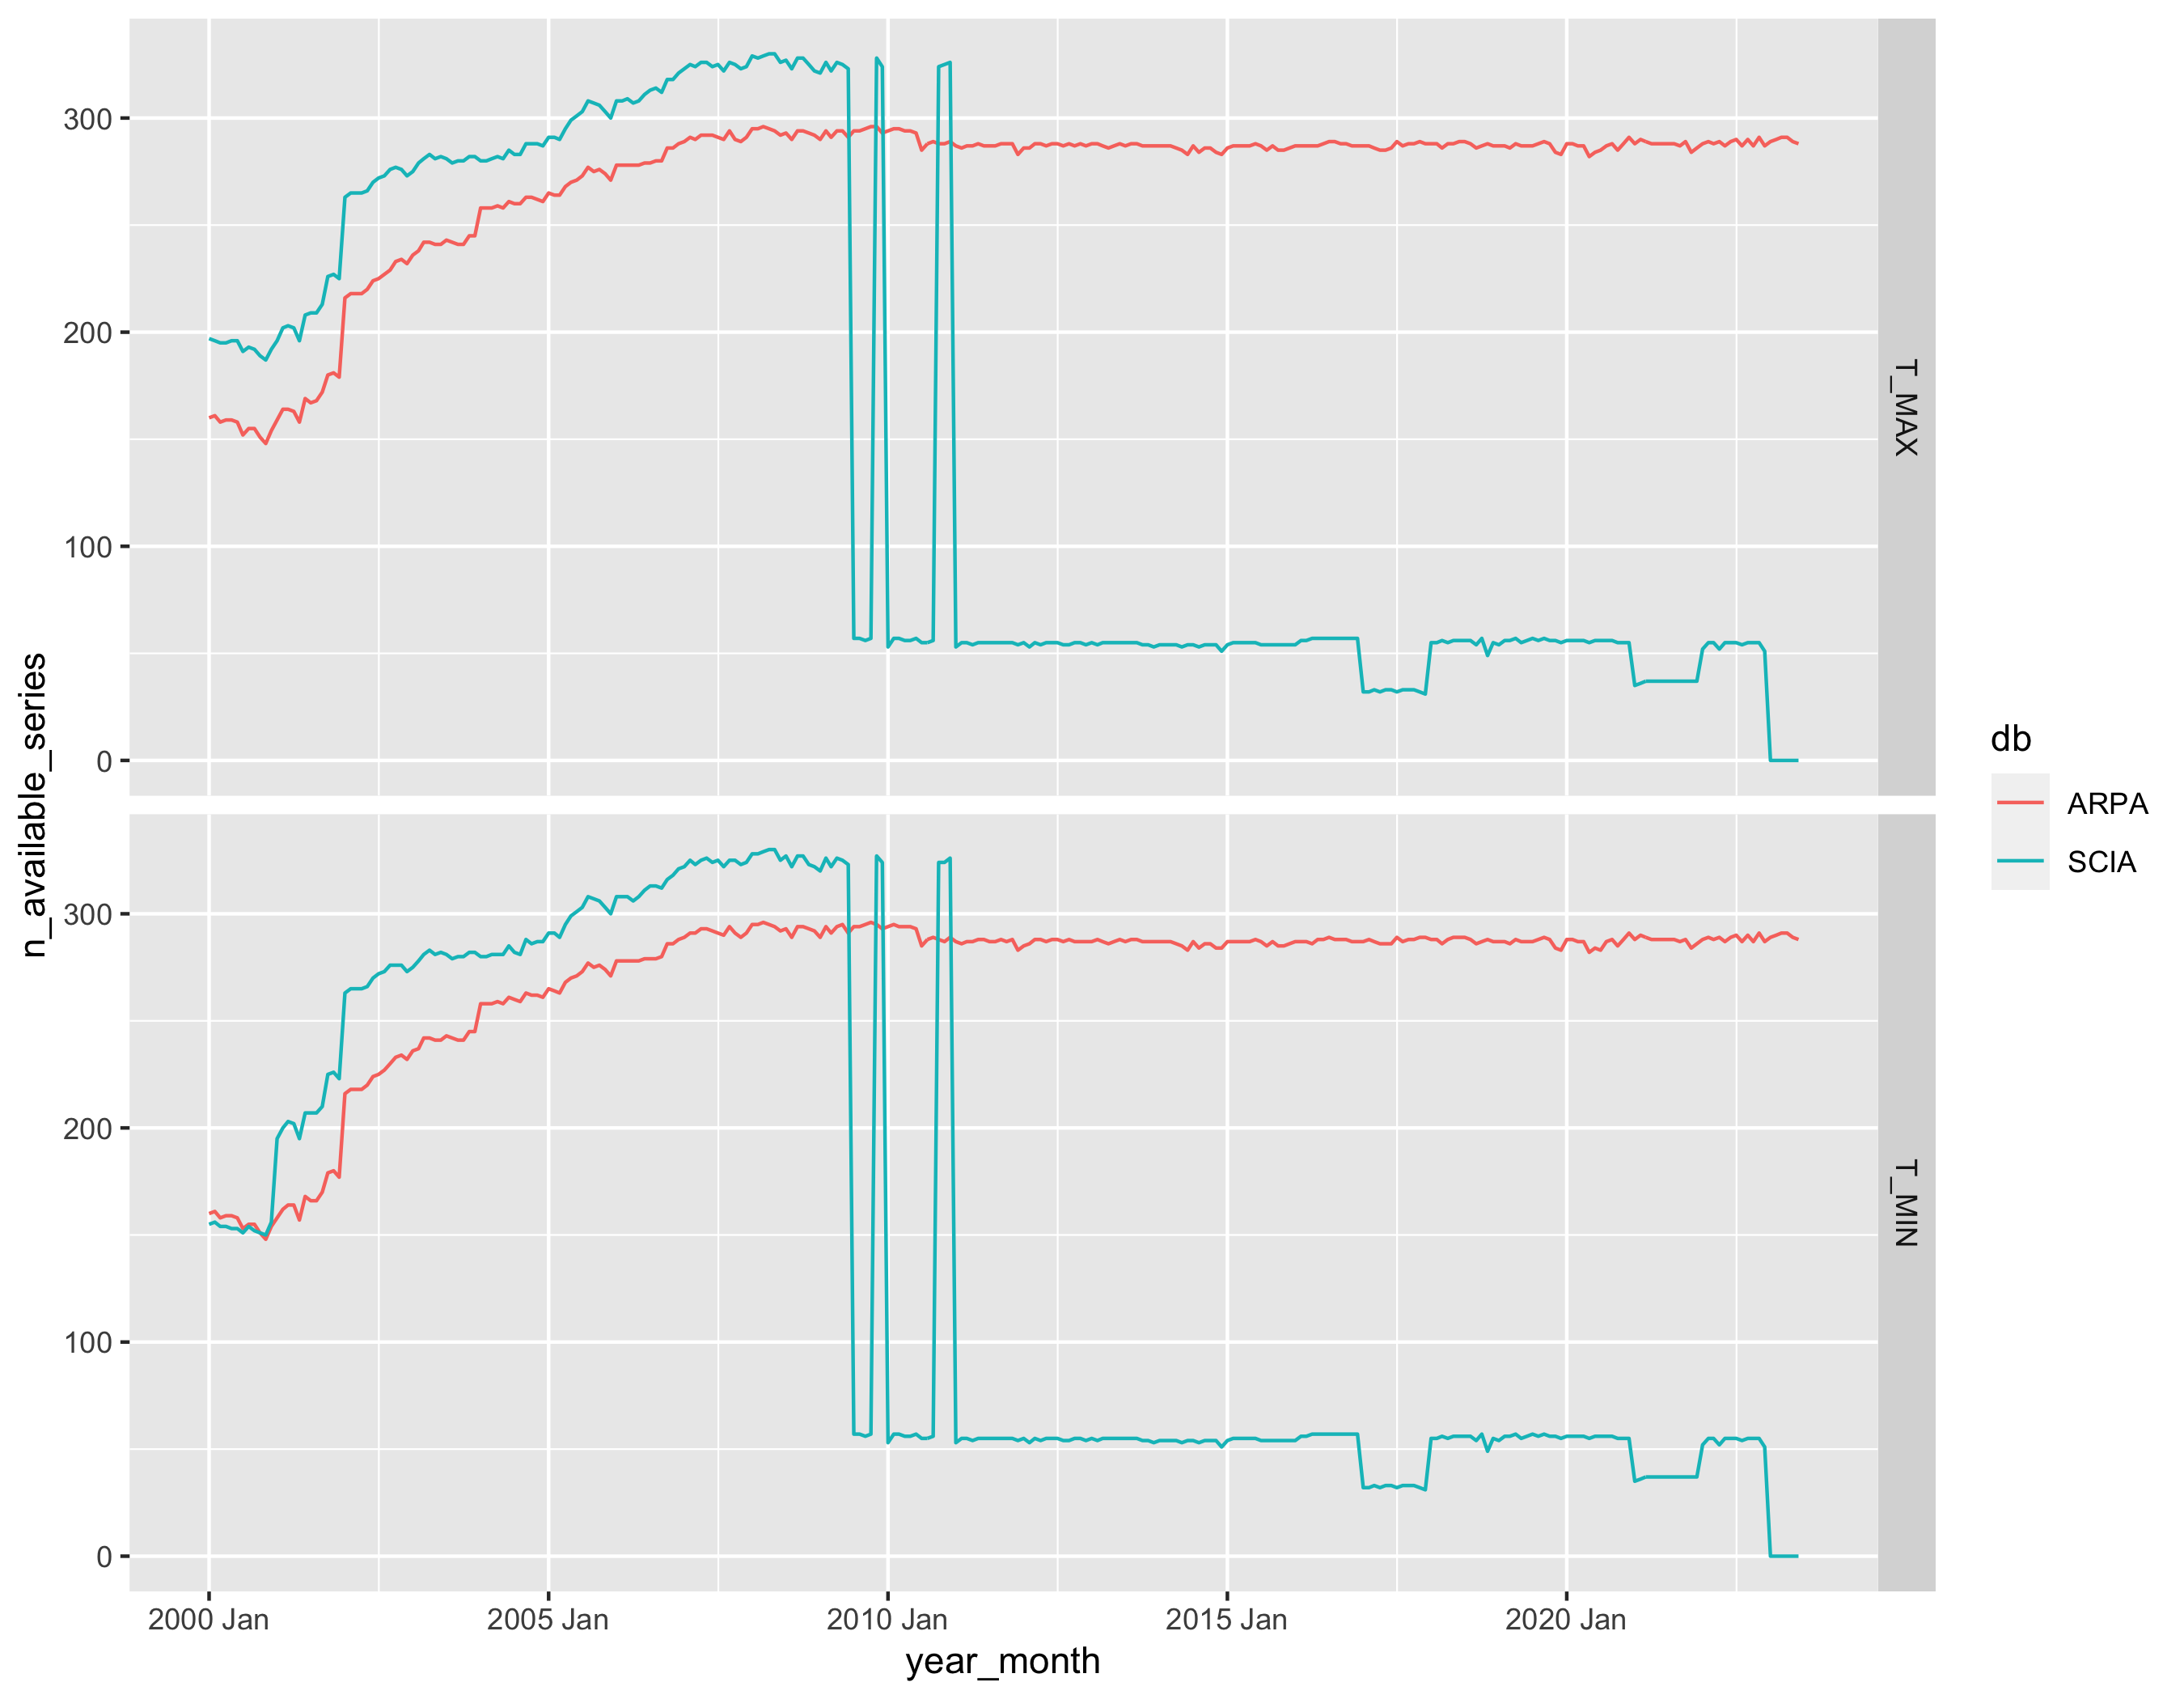

In [76]:
plot_state_avail(bind_rows(
    ARPA = arpa.ds |> collect(),
    SCIA = scia.ds |> mutate(identifier = cast(identifier, utf8())) |> collect(),
    .id = "db"
))


In [113]:
scia.metadata <- scia.metadata |>
    group_by(variable, anagrafica) |>
    arrange(first_date, .by_group = TRUE) |>
    slice_tail() |>
    ungroup()
matches <- matches_table(scia.metadata, arpa.metadata, dist_km = 0.5)


In [101]:
matches |>
    filter((anagrafica.x != str_remove_all(anagrafica.y, "'") & (anagrafica.x != comune))) |>
    select(starts_with("anag"), rete, comune, variable)


anagrafica.x,anagrafica.y,rete,comune,variable
<chr>,<chr>,<chr>,<chr>,<chr>
CANDIA,CANDIA LAGO,Idrografica,CANDIA CANAVESE,T_MAX
PALLANZA,PALLANZA LAGO MAGGIORE,Idrografica,VERBANIA,T_MAX
CANDIA,CANDIA LAGO,Idrografica,CANDIA CANAVESE,T_MIN
PALLANZA,PALLANZA LAGO MAGGIORE,Idrografica,VERBANIA,T_MIN


In [115]:
c(data.scia.tmax, data.scia.tmin) %<-% (open.dataset("SCIA", "data") |>
    widen_split_data(matches, identifier.x))

c(data.arpa.tmax, data.arpa.tmin) %<-% (arpa.ds |>
    widen_split_data(matches, identifier.y))


In [154]:
diffs <- compute_diffs(matches |> filter(variable == "T_MIN"), data.scia.tmin, data.arpa.tmin)


In [150]:
thresh <- c(0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99)
diffs |> reframe(diffs = quantile(diffs, probs = thresh, na.rm = TRUE), quant = thresh)


diffs,quant
<dbl>,<dbl>
-7.629395e-07,0.01
-3.814697e-07,0.05
-1.907349e-07,0.10
0.000000e+00,0.50
1.000000e-01,0.90
2.000000e-01,0.95
4.000002e-01,0.99


In [140]:
scia.metadata |>
    select(variable, rete, anagrafica, identifier, ends_with("date")) |>
    slice_head(n = 10)


variable,rete,anagrafica,identifier,first_date,last_date,geometry
<chr>,<chr>,<chr>,<int>,<date>,<date>,<POINT [arc_degree]>
T_MAX,Idrografica,ACCEGLIO,7332,1989-06-15,2010-12-31,POINT (6.981433 44.48515)
T_MAX,Idrografica,ACCEGLIO COLLET,7650,2004-08-27,2010-12-31,POINT (6.906438 44.52014)
T_MAX,Idrografica,ACQUI TERME,7300,1988-01-27,2010-12-31,POINT (8.479704 44.67867)
T_MAX,Regionale ARPA Piemonte,ALA DI STURA,5632,1993-07-23,2023-01-01,POINT (7.311 45.313)
T_MAX,Regionale ARPA Piemonte,ALAGNA,5638,2001-06-15,2023-01-01,POINT (7.937 45.875)
T_MAX,Regionale ARPA Piemonte,ALBA TANARO,5605,2003-01-31,2023-01-01,POINT (8.029 44.706)
T_MAX,Idrografica,ALBANO VERCELLESE,7310,1988-04-09,2010-12-31,POINT (8.388335 45.438)
T_MAX,Regionale ARPA Piemonte,ALESSANDRIA LOBBI,5600,1990-01-01,2023-01-01,POINT (8.705 44.938)
T_MAX,Regionale ARPA Piemonte,ALPE CHEGGIO,5644,1996-11-06,2023-01-01,POINT (8.117 46.086)


In [156]:
diffs |>
    left_join(scia.metadata |> filter(variable == "T_MAX") |> select(identifier, rete, anagrafica) |> mutate(identifier = as.character(identifier)), by = join_by(identifier.x == identifier)) |>
    filter(abs(diffs) > 3)


date,value.x,value.y,diffs,identifier.x,identifier.y,rete,anagrafica,geometry
<date>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<POINT [arc_degree]>
2002-04-26,5.3,10.1,-4.800000,5632,PIE-001003-900,Regionale ARPA Piemonte,ALA DI STURA,POINT (7.311 45.313)
2009-12-19,-13.1,-16.3,3.200000,5651,PIE-003010-900,Regionale ARPA Piemonte,ALPE DEVERO,POINT (8.261 46.317)
2004-09-08,14.0,10.8,3.200000,5650,PIE-003011-900,Regionale ARPA Piemonte,ANZINO,POINT (8.157 45.988)
2005-06-16,-6.9,11.6,-18.500000,7445,PIE-004091-901,Idrografica,BORELLO,POINT (7.833183 44.22376)
2002-08-12,-7.6,5.7,-13.300000,7298,PIE-004248-900,Idrografica,COLLE LOMBARDA,POINT (7.147733 44.20792)
2000-07-10,11.8,15.5,-3.700000,5628,PIE-001097-900,Regionale ARPA Piemonte,CUMIANA,POINT (7.392 44.965)
2014-05-15,6.5,2.2,4.300000,5628,PIE-001097-900,Regionale ARPA Piemonte,CUMIANA,POINT (7.392 44.965)
2000-06-01,2.4,6.6,-4.200000,5630,PIE-001073-900,Regionale ARPA Piemonte,LAGO AGNEL,POINT (7.14 45.469)
2010-01-04,-13.7,-17.8,4.100000,5630,PIE-001073-900,Regionale ARPA Piemonte,LAGO AGNEL,POINT (7.14 45.469)


In [16]:
analysis <- build_analysis(matches, data.scia.tmin, data.scia.tmax, data.arpa.tmin, data.arpa.tmax)


In [23]:
analysis |> sensible_columns()


variable,identifier.x,anagrafica.x,anagrafica.y,distance,f0,delH,delZ,delT,maeT,sdT,corT,monthlyslopeT,monthlydelT,monthlysdT,minilap,valid_days_union,valid_days_inters
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
T_MIN,7332,ACCEGLIO,ACCEGLIO,14.504918,0.20547112,35,0.00000,-5.561892e-10,1.212194e-07,1.757297e-07,1.0000000,-1.372781e-03,-0.008761243,0.53305319,1.0000000,8384,3290
T_MIN,7650,ACCEGLIO COLLET,ACCEGLIO COLLET,122.373552,0.19979079,16,0.00000,5.548189e-09,1.137188e-07,1.647773e-07,1.0000000,-2.905839e-03,-0.038604526,0.37660337,1.0000000,6674,1912
T_MIN,7300,ACQUI TERME,ACQUI TERME,6.264300,0.20365246,17,0.00000,-6.382678e-10,1.738966e-07,2.591925e-07,1.0000000,-1.047336e-03,-0.026216626,0.34053743,1.0000000,8390,3614
T_MIN,7409,ALA DI STURA,ALA DI STURA,15.815389,0.19155396,57,0.00000,5.816100e-09,1.267142e-07,1.803280e-07,1.0000000,-1.353660e-03,-0.029886103,0.22939153,1.0000000,8395,3623
T_MIN,5632,ALA DI STURA,ALA DI STURA,79.097432,0.12182620,0,0.00000,4.566694e-02,5.017293e-02,9.992546e-02,0.9998785,9.884211e-05,0.045420128,0.03093165,0.9997616,8397,8389
T_MIN,7471,ALAGNA,ALAGNA,4.399052,0.20454545,111,0.00000,2.568515e-09,1.205102e-07,1.728586e-07,1.0000000,-9.027920e-04,-0.016848403,0.22900616,1.0000000,7414,3080
T_MIN,5638,ALAGNA,ALAGNA,92.858540,0.03363133,151,0.00000,1.886051e-01,1.922095e-01,1.578286e-01,0.9996715,-1.683707e-04,0.188734939,0.07581133,0.9998581,7415,7047
T_MIN,7533,ALBA TANARO,ALBA TANARO,8.665996,0.19310897,9,0.00000,8.188475e-09,1.884603e-07,2.816291e-07,1.0000000,-1.797611e-03,-0.032776787,0.39425666,1.0000000,7267,2496
T_MIN,5605,ALBA TANARO,ALBA TANARO,143.145476,0.06899551,0,0.00000,8.476591e-02,9.053494e-02,9.958517e-02,0.9999171,6.752541e-04,0.093080445,0.11405433,0.9997102,7269,6899


In [183]:
arpa.data <- collect(arpa.ds) |> as_tsibble(index = date, key = c("identifier", "variable"))


In [187]:
clim_availablility <- is_climatology_computable(arpa.data |> group_by_key(), value, as.Date("2000-01-01"), as.Date("2022-12-31"))
plot_clim_availability(clim_availablility, arpa.metadata) + theme(title = text("From 2000-01-01"))

ERROR while rich displaying an object: Error in `mapply()`:
! The `title` theme element must be a <element_text> object.

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8

In [185]:
n_available_series(arpa.data, as.Date("2000-01-01"), as.Date("2022-12-31"))

[1] 470

In [186]:
n_available_series(arpa.data, as.Date("2002-01-01"), as.Date("2022-12-31"))

[1] 525

In [88]:
scia.internal_matches <- matches_table(scia.metadata, scia.metadata, dist_km = 0.5) |>
    filter(identifier.x > identifier.y) |>
    mutate(match_id = row_number())


In [89]:
scia.analysis <- build_analysis(
    scia.internal_matches |>
        mutate(across(starts_with("identi"), ~ as.character(.))) |>
        select(starts_with("identif"), starts_with("anag"), starts_with("elev"), variable, starts_with("dem"), distance, match_id),
    data.scia.tmin, data.scia.tmax, data.scia.tmin, data.scia.tmax
)


In [90]:
scia.analysis |> sensible_columns()


variable,identifier.x,anagrafica.x,anagrafica.y,distance,f0,delH,delZ,delT,maeT,sdT,corT,monthlyslopeT,monthlydelT,monthlysdT,minilap,valid_days_union,valid_days_inters
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
T_MIN,7409,ALA DI STURA,ALA DI STURA,79.77510,0.6306928,57,0.000000,-0.03872481,0.04772288,0.11470668,0.9998456,-1.310091e-03,-0.06780743,0.2310476,1.0000000,8391,3623
T_MIN,7471,ALAGNA,ALAGNA,97.04664,0.2126623,262,0.000000,-0.19879870,0.20516234,0.19094945,0.9995238,-3.418459e-04,-0.21433048,0.2413701,1.0000000,7048,3080
T_MIN,7533,ALBA TANARO,ALBA TANARO,141.45224,0.5484776,9,0.000000,-0.04615384,0.05993589,0.08754747,0.9999354,-1.905528e-03,-0.08073666,0.3965665,1.0000000,6901,2496
T_MIN,7313,ALESSANDRIA LOBBI,ALESSANDRIA LOBBI,128.49060,0.5044519,2,0.000000,-0.06508069,0.07270451,0.10491355,0.9998928,-1.510294e-04,-0.07354457,0.4147568,1.0000000,7981,3594
T_MIN,7353,ALPE CHEGGIO,ALPE CHEGGIO,143.56014,0.3258396,157,57.308838,-0.17013600,0.17824036,0.23079579,0.9994546,5.399460e-04,-0.16288770,0.2945406,1.0000000,7998,3603
T_MIN,7348,ALPE DEVERO,ALPE DEVERO,131.02943,0.2364996,18,30.190552,-0.26422044,0.27396844,0.28732084,0.9991907,1.145180e-03,-0.27749970,0.2401048,1.0000000,7999,3611
T_MIN,7354,ANZINO,ANZINO,161.71767,0.4321439,46,0.000000,-0.08917354,0.10112840,0.17690449,0.9996311,-9.570099e-04,-0.10768380,0.2371900,0.9996951,7698,3279
T_MIN,7336,ASTI TANARO,ASTI TANARO,135.88933,0.5419784,1,0.000000,-0.04624550,0.06120810,0.11159451,0.9998917,-7.213400e-04,-0.06577891,0.3455617,1.0000000,7657,3609
T_MIN,7566,BIELLA,BIELLA,183.37340,0.4441370,6,0.000000,-0.07976479,0.09885853,0.17406821,0.9997018,-3.256219e-03,-0.10612718,0.2679419,1.0000000,7389,2891


In [91]:
scia.merged.tmin <- update_left(scia.analysis |> filter(variable == "T_MIN"), data.scia.tmin, data.scia.tmin) |> left_join(scia.internal_matches |> select(variable, starts_with("identif"), match_id) |> mutate(match_id = as.character(match_id)), by = "match_id", relationship = "many-to-one")
scia.merged.tmax <- update_left(scia.analysis |> filter(variable == "T_MAX"), data.scia.tmax, data.scia.tmax) |>
    left_join(scia.internal_matches |> select(variable, starts_with("identif"), match_id) |> mutate(match_id = as.character(match_id)), by = "match_id", relationship = "many-to-one")


In [92]:
scia.merged.tmin |> filter(from.dpc)


value,date,match_id,from.dpc,correction,variable,identifier.x,identifier.y
<dbl>,<date>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<chr>
-2.7506729,2000-02-25,49,TRUE,-0.05067287,T_MIN,7409,5632
0.4659336,2000-04-19,49,TRUE,-0.03406636,T_MIN,7409,5632
8.2644638,2007-04-14,49,TRUE,-0.03553638,T_MIN,7409,5632
NA,2007-11-27,49,TRUE,-0.05332032,T_MIN,7409,5632
NA,2007-11-28,49,TRUE,-0.05386361,T_MIN,7409,5632
0.9641236,2008-04-12,49,TRUE,-0.03587641,T_MIN,7409,5632
11.9786813,2009-07-03,49,TRUE,-0.02131872,T_MIN,7409,5632
11.5787641,2009-07-04,49,TRUE,-0.02123629,T_MIN,7409,5632
10.4788433,2009-07-05,49,TRUE,-0.02115668,T_MIN,7409,5632


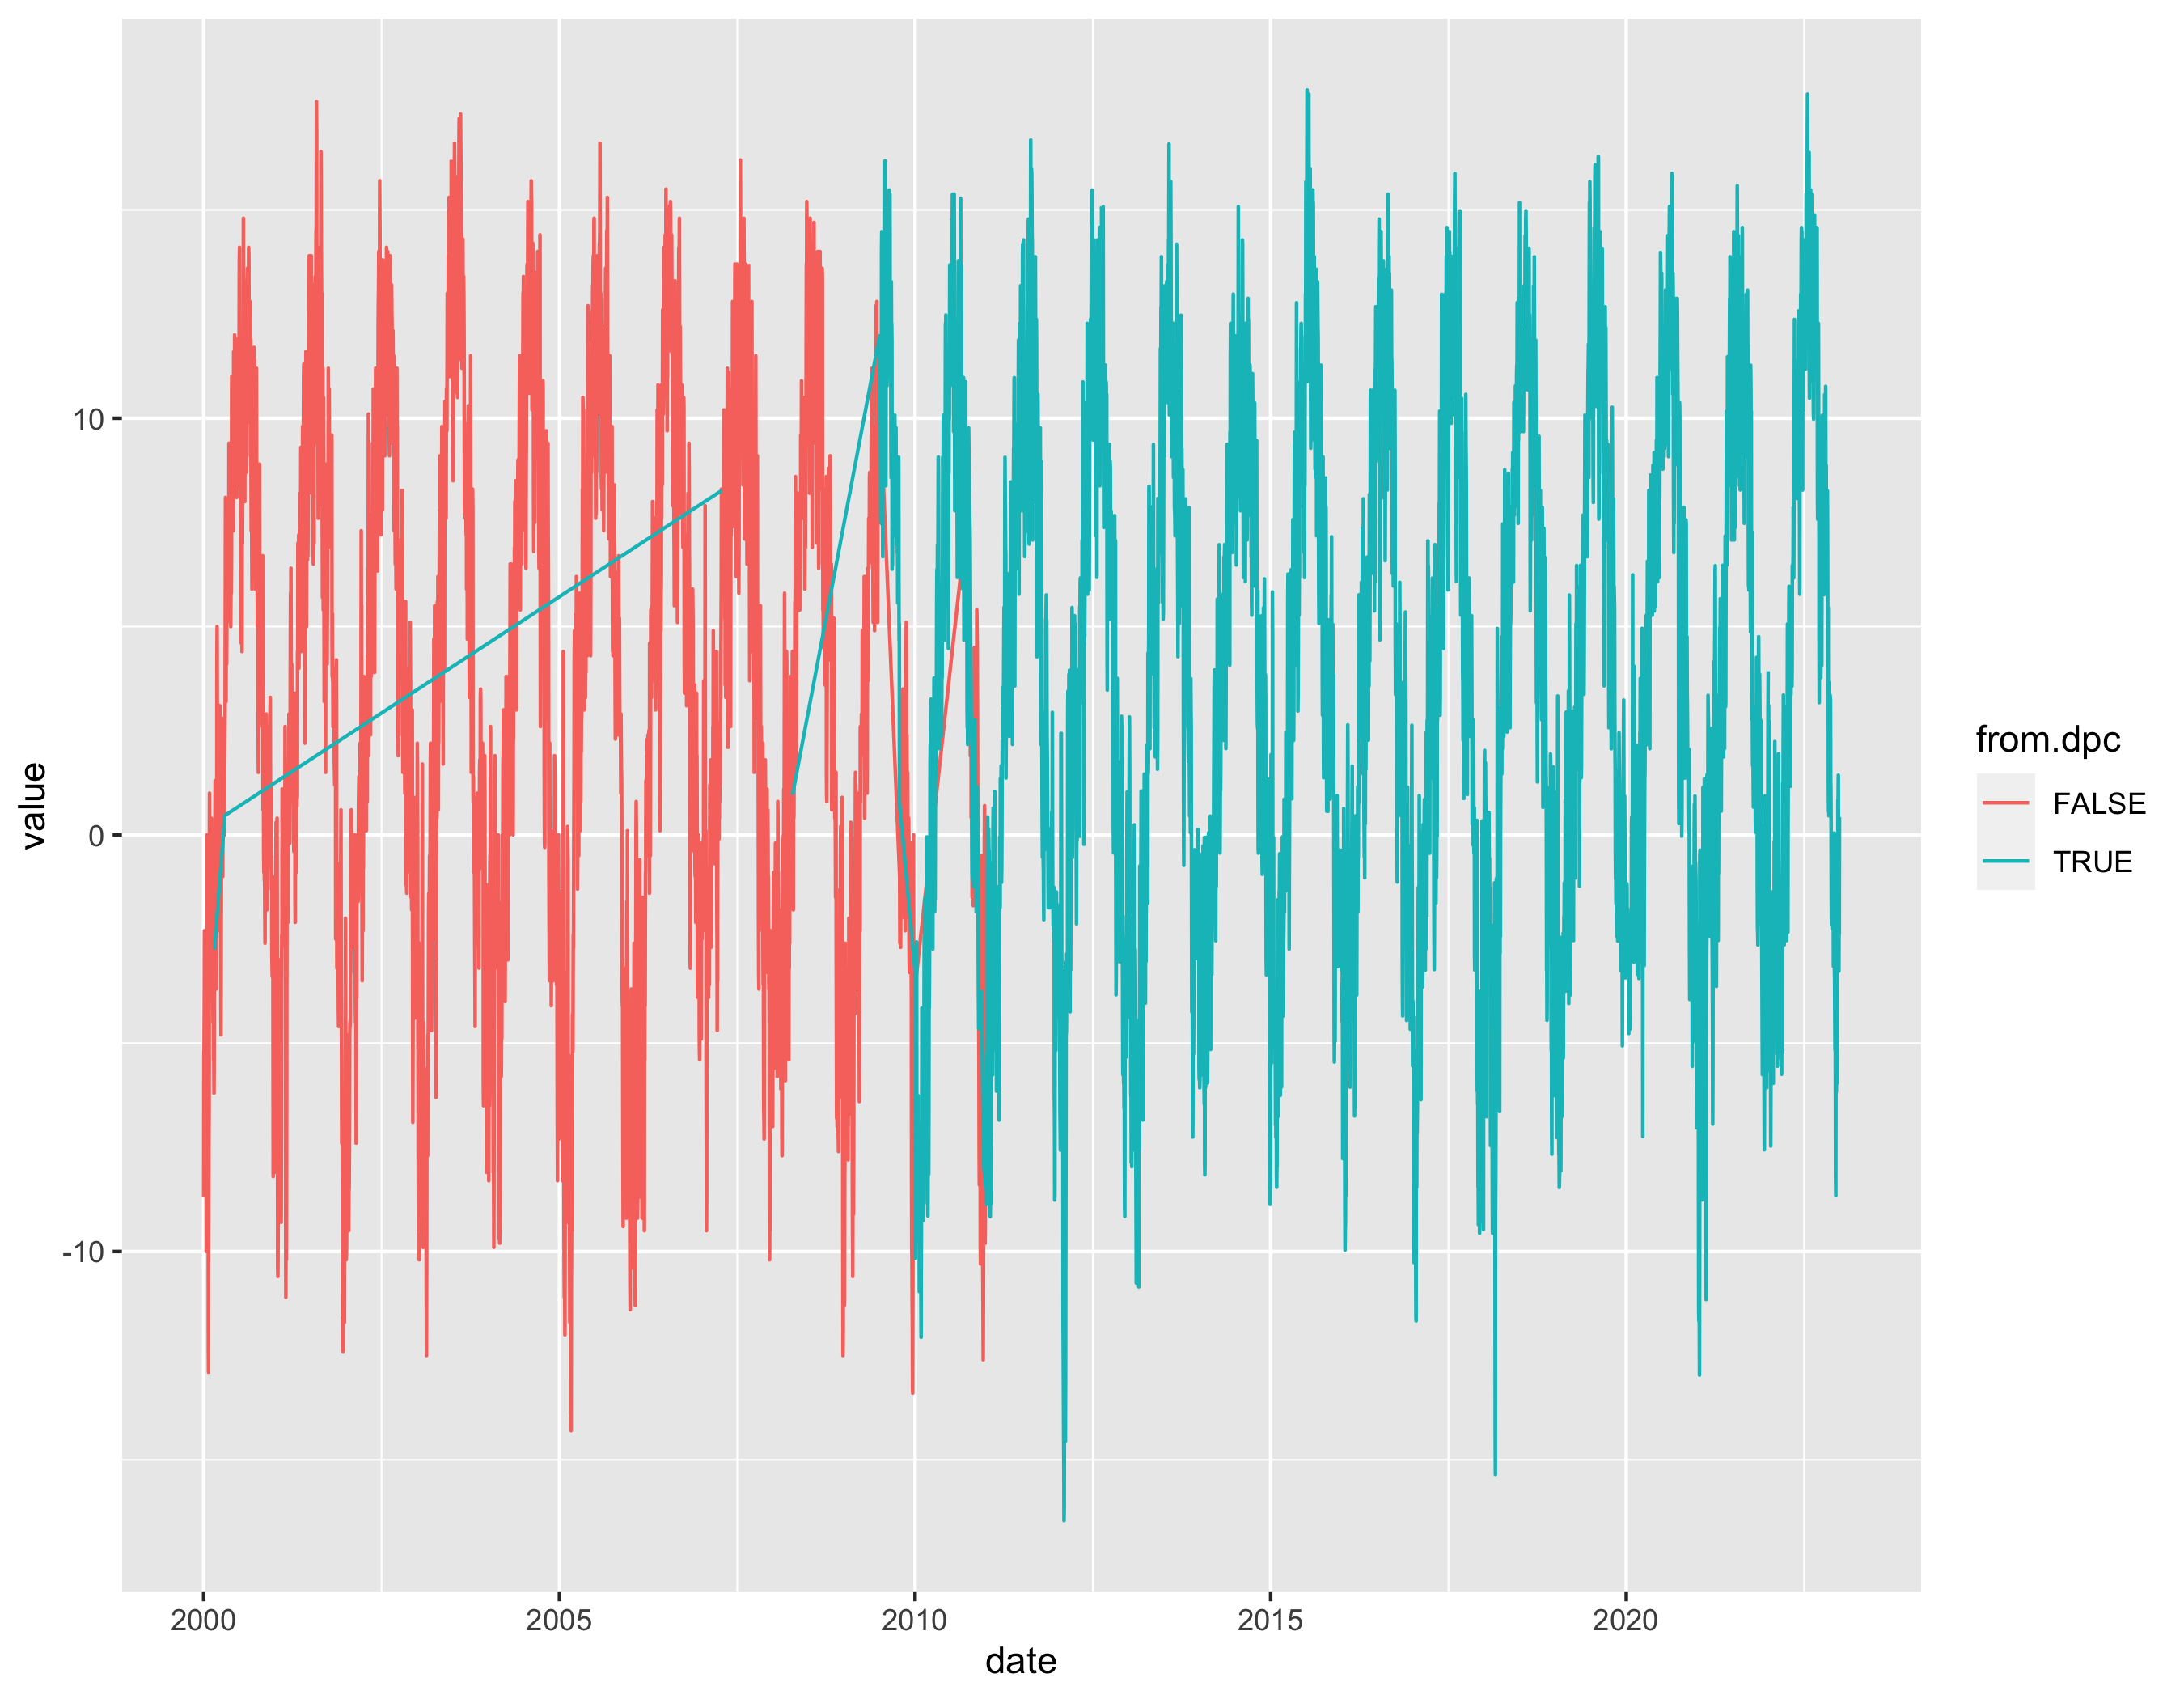

In [95]:
scia.merged.tmin |>
    filter(match_id < 50) |>
    ggplot(aes(date, value, color = from.dpc)) +
    geom_line()


In [77]:
arpa.internal_matches <- matches_table(arpa.metadata, arpa.metadata, dist_km = 0.01) |>
    filter(data_inizio_sensore.x != data_inizio_sensore.y) |>
    mutate(match_id = row_number())


In [78]:
arpa.internal_matches |> select(starts_with("identi"), starts_with("anag"))


identifier.x,identifier.y,anagrafica.x,anagrafica.y
<chr>,<chr>,<chr>,<chr>


In [79]:
arpa.metadata


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,variable,data_inizio_sensore,data_fine_sensore,quota_da_pc,elevation,esposizione,tipo_staz,sigla_prov,comune,anagrafica,indirizzo_localita,identifier,geometry,dem
,<chr>,<date>,<date>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<POINT [arc_degree]>,<dbl>
1,T_MAX,1993-07-22,NA,0,1006,N,HPT,TO,ALA DI STURA,ALA DI STURA,VIVAIO FORESTALE LA FABBRICA,PIE-001003-900,POINT (7.31028 45.3125),1074.3340
2,T_MAX,1999-09-08,NA,0,1580,SSE,PRT,TO,ANDRATE,ANDRATE PINALBA,PINALBA,PIE-001010-900,POINT (7.89222 45.56111),1579.3303
3,T_MAX,1999-08-05,NA,0,1435,S,PT,TO,ANGROGNA,VACCERA,VACCERA,PIE-001011-900,POINT (7.20167 44.875),1274.3535
4,T_MAX,1991-01-09,NA,0,340,N,HPRTV,TO,AVIGLIANA,AVIGLIANA,GRANGIA,PIE-001013-900,POINT (7.39472 45.09389),343.8215
5,T_MAX,1987-09-25,NA,0,2659,N,NPRTV,TO,BALME,RIFUGIO GASTALDI,RIFUGIO GASTALDI,PIE-001019-900,POINT (7.14333 45.29806),2622.4207
6,T_MAX,2018-04-18,NA,0,1410,ENE,PTV,TO,BALME,BALME,FRAZIONE CORNETTI,PIE-001019-901,POINT (7.22194 45.3025),1526.8475
7,T_MAX,1990-12-06,NA,0,1290,WSW,BHNPRTV,TO,BARDONECCHIA,PRERICHARD,PRERICHARD,PIE-001022-900,POINT (6.71639 45.075),1351.1584
8,T_MAX,1990-11-09,2005-08-30,0,1740,WSW,BHNPRTV,TO,BARDONECCHIA,CAMINI FREJUS,CAMINI FREJUS,PIE-001022-901,POINT (6.68861 45.11722),1935.2462
9,T_MAX,2002-10-10,2010-07-22,0,1791,NW,GHPRTV,TO,BARDONECCHIA,BARDONECCHIA MELEZET,MELEZET,PIE-001022-902,POINT (6.68583 45.045),1743.5492
